Model Accuracy: 0.77


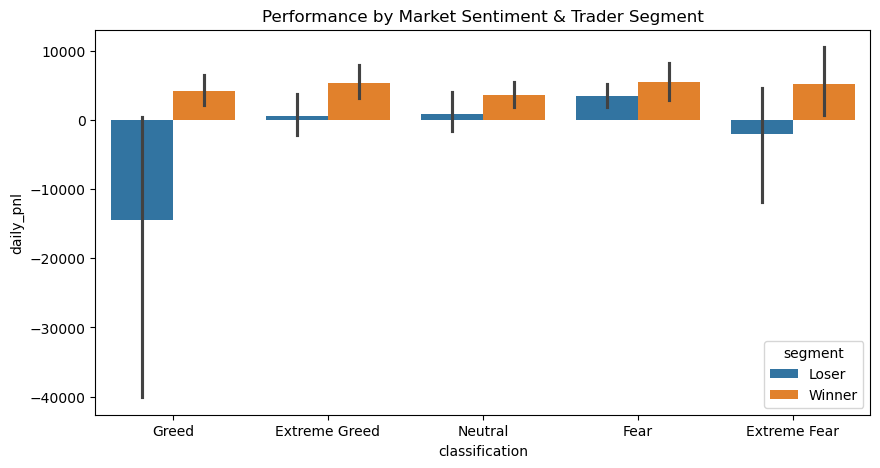

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 1. LOAD & CLEAN
sentiment = pd.read_csv(r'C:\Users\srial\OneDrive\Desktop\trader-sentiment-analysis\Trader-Market-sentiment-analysis\data\fear_greed_index (1).csv')
trades = pd.read_csv(r'C:\Users\srial\OneDrive\Desktop\trader-sentiment-analysis\Trader-Market-sentiment-analysis\data\historical_data (1).csv')

sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date
trades['date'] = pd.to_datetime(trades['Timestamp IST'], format='%d-%m-%Y %H:%M').dt.date

# 2. FEATURE ENGINEERING
daily_stats = trades.groupby(['date', 'Account']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    trade_count=('Trade ID', 'count'),
    total_size_usd=('Size USD', 'sum'),
    long_count=('Side', lambda x: (x == 'BUY').sum()),
    short_count=('Side', lambda x: (x == 'SELL').sum())
).reset_index()

daily_stats['long_ratio'] = daily_stats['long_count'] / (daily_stats['long_count'] + daily_stats['short_count'])
daily_stats['win_rate'] = (daily_stats['daily_pnl'] > 0).astype(int)

# Merge
df = pd.merge(daily_stats, sentiment[['date', 'classification', 'value']], on='date')

# 3. SEGMENTATION
trader_profiles = trades.groupby('Account').agg(total_pnl=('Closed PnL', 'sum')).reset_index()
trader_profiles['segment'] = trader_profiles['total_pnl'].apply(lambda x: 'Winner' if x > 0 else 'Loser')
df = pd.merge(df, trader_profiles, on='Account')

# 4. PREDICTIVE MODEL (Bonus)
X = df[['value', 'trade_count', 'total_size_usd', 'long_ratio']].fillna(0)
y = df['win_rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = RandomForestClassifier().fit(X_train, y_train)
print(f"Model Accuracy: {model.score(X_test, y_test):.2f}")

# 5. VISUALIZATION
plt.figure(figsize=(10,5))
sns.barplot(x='classification', y='daily_pnl', hue='segment', data=df)
plt.title('Performance by Market Sentiment & Trader Segment')
plt.savefig('sentiment_performance.png')